# Exploring estimation of Rt for Indian states using Turing.jl

The data I'll be pulling in live identifies Indian states using their two-letter codes. So I need a table that translates them to their full names.

Rt values for Indian states (the "effective reproduction number") calculated according to the model described by Kevin Systrom (his [jupyter notebook](https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb)).

In [1]:
using HTTP, JSON

india_state_codes = Dict(
    "ap" => "Andhra Pradesh",
    "ar" => "Arunachal Pradesh",
    "as" => "Assam",
    "br" => "Bihar",
    "ct" => "Chhattisgarh",
    "ga" => "Goa",
    "gj" => "Gujarat",
    "hr" => "Haryana",
    "hp" => "Himachal Pradesh",
    "jh" => "Jharkhand",
    "ka" => "Karnataka",
    "kl" => "Kerala",
    "mp" => "Madhya Pradesh",
    "mh" => "Maharashtra",
    "mn" => "Manipur",
    "ml" => "Meghalaya",
    "mz" => "Mizoram",
    "nl" => "Nagaland",
    "or" => "Odisha",
    "pb" => "Punjab",
    "rj" => "Rajasthan",
    "sk" => "Sikkim",
    "tn" => "Tamil Nadu",
    "tg" => "Telangana",
    "tr" => "Tripura",
    "ut" => "Uttarakhand",
    "up" => "Uttar Pradesh",
    "wb" => "West Bengal",
    "an" => "Andaman and Nicobar Islands",
    "ch" => "Chandigarh",
    "dn" => "Dadra and Nagar Haveli",
    "dd" => "Daman and Diu",
    "dl" => "Delhi",
    "jk" => "Jammu and Kashmir",
    "la" => "Ladakh",
    "ld" => "Lakshadweep",
    "py" => "Puducherry",
    "in" => "INDIA"
);

## Getting the data

Grab the "state-wise daily" data from https://covid19india.org . They provide mostly straightforward JSON API end points to grab the data.

In [2]:
# Grab the data
state_wise_dailies = JSON.parse(String(HTTP.get("https://api.covid19india.org/states_daily.json").body))    
ignorable_tail = 0

# Make a function to extract state-wise. We skip the last data point since it can be in error quite often.
dailies_for_state(state_code) = [parse(Int, x[state_code]) for x in state_wise_dailies["states_daily"] if x["status"] === "Confirmed"][1:end-ignorable_tail]
state_data_available(state_code) = all([haskey(x, state_code) && (tryparse(Int, x[state_code]) !== nothing) for x in state_wise_dailies["states_daily"] if x["status"] === "Confirmed"])

# Also make a note of the date series to keep track of which dat each data point corresponds to.
date_series = [x["date"] for x in state_wise_dailies["states_daily"] if x["status"] === "Confirmed"][1:end-ignorable_tail]

println("Computing estimates for ", date_series[end])

Computing estimates for 07-May-20


## Filtering the data

We normally want to filter the data because there is considerable noise from day to day in the per-state dataset. We know that the state-wise data is going to give us some significant variance in the Rt estimates due to the interventions in effect, so the filtering may not have that much of an impact.

However, we do need the filter to satisfy some key properties -

1. It must preserve the total number of cases.
2. At the ends, it must assume the status quo at the worst. This means constant padding must be used.

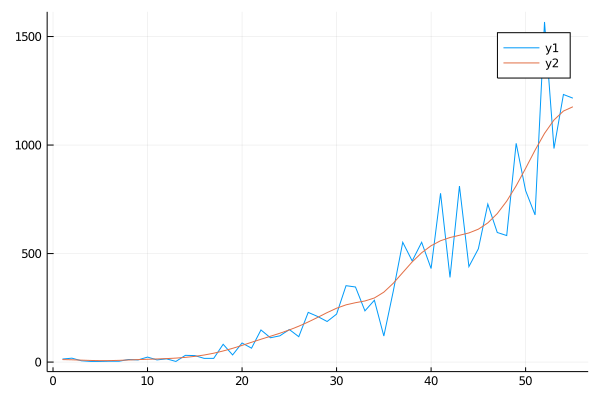

In [3]:
filter(x) = [
    [0.75*x[1] + 0.25*x[2]];
    [0.25 * x[i-1] + 0.5*x[i] + 0.25*x[i+1] for i in 2:(length(x) - 1)];
    [0.25*x[end-1] + 0.75*x[end]]
]
filter(x,n) = if n === 0 x else filter(filter(x),n-1) end

using StatsPlots
plot([dailies_for_state("tn"), filter(dailies_for_state("tn"),10)])

## Making a "true" filter

Applying a short gaussian repeatedly gives a nice enough filter for most purposes. However, it has one flaw - it needs to make an assumption about how the values progress beyond the ends of the array, and the consequences of this decision seep into the ends of the filtered output such that you have to discard values close to the ends.

Usually, the choice made is to keep the values fixed at the end and extend them. This is unacceptable for our purposes, because it will skew the Rt values downwards near the ends since the daily rate of cases will be seen to be starting to become constant (and hence Rt -> 0) near the ends. 

What we really want is a semblance of Rt being held constant beyond the ends. To get this behaviour, instead of filtering the daily cases, we can filter the daily log ratio of cases and then back calculate the series from the smoothed value. With this approach, the ratio will be seen to held constant beyond the edges, meaning we'll get closer to a trend projection for Rt.

One option we have at hand is of course to discard values near the edge and apply usual filtering of the daily cases. However, that doesn't help us since we will only have Rt values for 5 days ago .. which isn't quite "real time". Filtering the log ratio series is better from that perspective.

In the end, I chose to apply an causal decaying filter on the raw case arrivals first to prevent excessive influence of the latest daily figure, followed by the log ratio filter to stabilize Rt near the end.

#### There is no "true" filter

I think the bottomline is that given the weekly cycles embedded into the case reporting, we have to live with about a week's latency for a reliable Rt estimate. Any attempts to reduce the latency for a reliable estimate can only mean we have a filter that's already capable of predicting Rt a week into the future .. which unless no variation in action is seen over the previous couple of weeks or so and aren't planned for the coming week, is close to clairvoyance or at the least requires rich data from diverse sources. This means, we're essentially estimating Rt for a week ago .. which I think is still valuable. I only want to avoid giving the false impression of "Rt has been going down over the past few days" just because I used an inappropriate assumption for the filter.

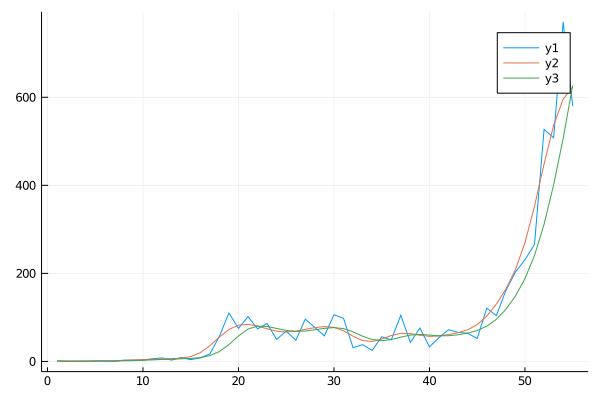

In [191]:
fir2filter(x,coeff) = [i > 1 ? x[i] * coeff + x[i-1] * (1.0-coeff) : x[1] for i in 1:length(x)]
truefilter(x,n) = begin
    for i in 1:n
        x = fir2filter(x, 0.75) # Reduce excessive influence of the latest data point.
    end
    tf = filter([log(max(1,x[i])/max(1,x[i+1])) for i in 1:(length(x)-1)],n)
    # Add back the ending value.
    vcat([x[end]*exp(v) for v in reverse(cumsum(reverse(tf)))],[x[end]])
end
    
using StatsPlots
compare_filters(state) = begin
    data = dailies_for_state(state)
    plot([data, filter(data, 5), truefilter(data,5)])
end
compare_filters("tn")

You can see how the green line (the "truefilter") lurches upward near the end of the series whereas the red line (the "filter") flattens out. This is the difference we're looking for. I filtered 40 times just to illustrate the end effect.

## Making the model

The idea behind the model is really quite simple. We have a formula to estimate the next day's case arrival rate based on the current day's case arrival rate and the current value of Rt. What we don't know is the Rt itself, so we can assume a distribution for it, assume that it varies a little bit from day to day, and iteratively estimate it day to day.

In [115]:
using Turing, StatsPlots, Random, Distributions, AxisArrays

# Data available via dailies_for_state("tn") and the like.

# The transmission factor of the disease. Estimated by epidemiologists.
covid_gamma = 1.0/7.0

# Calculate Poisson rate from the value of Rt and the known k.
# Reference: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185
case_arrival_rate(k, rt, g=covid_gamma) = max(1,k) * exp(g * (rt - 1))

@model rtmodel(k, ::Type{T} = Vector{Float64}) where {T} = begin    
    # Create result vector we want to estimate
    rt = T(undef, length(k))
    
    # Priors
    rt[1] ~ Gamma(1.5)
    k[1] ~ Poisson(k[1])
    
    # The chain
    for t in 2:length(k)
        # Assume Rt can vary from day to day with a std deviation of 0.15
        # The ideal value was arrived at in Keivn Systrom's optimization and 
        # I'm choosing a more conservative value than 0.25.
        rt[t] ~ Normal(rt[t-1], 0.15)
        
        # Mark the observation that the Poisson should fit.
        k[t] ~ Poisson(case_arrival_rate(k[t-1], rt[t]))
    end
end

# Wrap the sampler into a function that produces the chain.
run(data) = sample(rtmodel(data), NUTS(), 3000)

run (generic function with 1 method)

## Run the model on the data

We run it for only the last 21 days. Don't care too much about the history, as the Rt values will settle reasonably. We also apply the 121-discrete-gaussian filter 5 times to smooth the daily data. We then pick the states with more than 20 cases to run the estimation, and accumulate the results into the `rt_results` Dict.

In [116]:
history_length = 31
smoothing = 5

filtered_state_data(code) = map(x -> trunc(Int,round(x)),truefilter(dailies_for_state(code), smoothing))[(end-history_length+1):end]
prec100(n) = round(n * 100) / 100

run_for_state(input) = begin
    c = run(input)
    d = Dict("rt" => [], "std" => [], "p05" => [], "p25" => [], "p75" => [], "p95" => [])
    for i in 1:length(input)
        data = dropdims(c["rt[" * string(i) * "]"].value.data, dims=(2,3))
        push!(d["rt"], prec100(mean(data)))
        push!(d["std"], prec100(std(data)))
        push!(d["p05"], prec100(quantile(data, 0.05)))
        push!(d["p25"], prec100(quantile(data, 0.25)))
        push!(d["p75"], prec100(quantile(data, 0.75)))
        push!(d["p95"], prec100(quantile(data, 0.95)))
    end
    d
end

run_for_state (generic function with 1 method)

In [117]:
rt_results = Dict()

for (state_code, state_name) in india_state_codes
    if state_data_available(state_code)
        println(state_code, " => ", state_name)
        input = filtered_state_data(state_code)
        if sum(input) > 20
            rt_results[state_code] = run_for_state(input)
        end
    end
end

ka => Karnataka


┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/srikumar/.julia/packages/Turing/cReBm/src/inference/hmc.jl:556
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:29


nl => Nagaland
jk => Jammu and Kashmir


┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/srikumar/.julia/packages/Turing/cReBm/src/inference/hmc.jl:556
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:27


sk => Sikkim
dl => Delhi


┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/srikumar/.julia/packages/Turing/cReBm/src/inference/hmc.jl:556
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:16


ld => Lakshadweep
hp => Himachal Pradesh


┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/srikumar/.julia/packages/Turing/cReBm/src/inference/hmc.jl:556
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:38


jh => Jharkhand


┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/srikumar/.julia/packages/Turing/cReBm/src/inference/hmc.jl:556
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:35


hr => Haryana


┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/srikumar/.julia/packages/Turing/cReBm/src/inference/hmc.jl:556
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:28


pb => Punjab


┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/srikumar/.julia/packages/Turing/cReBm/src/inference/hmc.jl:556
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:27


dd => Daman and Diu
mh => Maharashtra


┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/srikumar/.julia/packages/Turing/cReBm/src/inference/hmc.jl:556
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:12


mz => Mizoram
or => Odisha


┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/srikumar/.julia/packages/Turing/cReBm/src/inference/hmc.jl:556
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:34


tn => Tamil Nadu


┌ Info: Found initial step size
│   ϵ = 0.043750000000000004
└ @ Turing.Inference /home/srikumar/.julia/packages/Turing/cReBm/src/inference/hmc.jl:556
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:18


br => Bihar


┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/srikumar/.julia/packages/Turing/cReBm/src/inference/hmc.jl:556
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:27


kl => Kerala


┌ Info: Found initial step size
│   ϵ = 0.0484375
└ @ Turing.Inference /home/srikumar/.julia/packages/Turing/cReBm/src/inference/hmc.jl:556
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:31


rj => Rajasthan


┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/srikumar/.julia/packages/Turing/cReBm/src/inference/hmc.jl:556
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:17


ut => Uttarakhand
ct => Chhattisgarh


┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/srikumar/.julia/packages/Turing/cReBm/src/inference/hmc.jl:556
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:38


gj => Gujarat


┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/srikumar/.julia/packages/Turing/cReBm/src/inference/hmc.jl:556
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:15


ml => Meghalaya
up => Uttar Pradesh


┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/srikumar/.julia/packages/Turing/cReBm/src/inference/hmc.jl:556
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:19


an => Andaman and Nicobar Islands
ch => Chandigarh


┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/srikumar/.julia/packages/Turing/cReBm/src/inference/hmc.jl:556
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:35


ar => Arunachal Pradesh
wb => West Bengal


┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/srikumar/.julia/packages/Turing/cReBm/src/inference/hmc.jl:556
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:24


tr => Tripura


┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/srikumar/.julia/packages/Turing/cReBm/src/inference/hmc.jl:556
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:39


dn => Dadra and Nagar Haveli
ga => Goa
la => Ladakh
ap => Andhra Pradesh


┌ Info: Found initial step size
│   ϵ = 0.043750000000000004
└ @ Turing.Inference /home/srikumar/.julia/packages/Turing/cReBm/src/inference/hmc.jl:556
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:21


mn => Manipur
py => Puducherry
as => Assam


┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/srikumar/.julia/packages/Turing/cReBm/src/inference/hmc.jl:556
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:40


tg => Telangana


┌ Info: Found initial step size
│   ϵ = 0.046875
└ @ Turing.Inference /home/srikumar/.julia/packages/Turing/cReBm/src/inference/hmc.jl:556
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:26


Write the results out to a file as JSON so we can use it in visualization on the blog.

In [118]:
open("data/rt_daily.json", "w") do f
    JSON.print(f, rt_results)
end

The `rt_results` structure contains estimates for all the states for all the 21 days. We only want for the latest day's point. So create a summary object from it and write that out separately. We'll come to the full time series visualization at a later time. Include the basic info along with the estimates of Rt.

In [119]:
rt_summary = Dict(
    "date" => date_series[end],
    "states" => sort([
            Dict(
                "state_code"=>uppercase(state),
                "state_name"=>india_state_codes[state],
                "daily_cases"=>dailies_for_state(state)[end],
                "date"=>date_series[end],
                "p95"=>x["p95"][end],
                "p25"=>x["p25"][end],
                "p05"=>x["p05"][end],
                "rt"=>x["rt"][end],
                "p75"=>x["p75"][end],
                "std"=>x["std"][end])
            for (state,x) in rt_results],
        lt=(a,b)->a["rt"] > b["rt"])
)
open("data/rt_daily_summary.json","w") do f
    JSON.print(f, rt_summary)
end

┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/srikumar/.julia/packages/Turing/cReBm/src/inference/hmc.jl:556
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:56


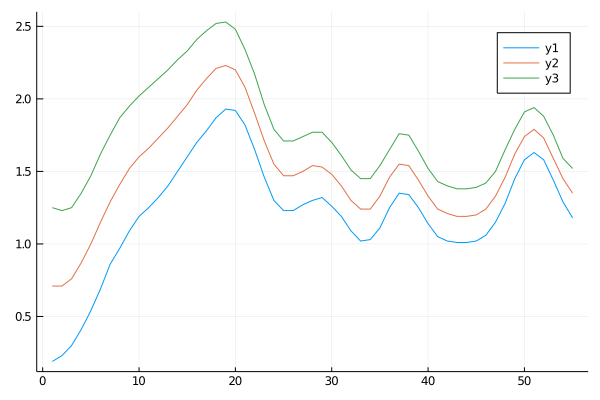

In [120]:
india = sum([dailies_for_state(code) for code in keys(india_state_codes) if state_data_available(code)])
rt_india = run_for_state(map(x -> trunc(Int, round(x)), truefilter(india, 5)))
plot([rt_india["p05"],rt_india["rt"],rt_india["p95"]])

In [121]:
rt_india["daily_cases"] = india
rt_india["date"] = date_series

open("data/rt_india.json", "w") do f
    JSON.print(f, rt_india)
end

In [122]:
plot_state(sc) = plot([rt_results[sc]["p05"],rt_results[sc]["rt"],rt_results[sc]["p95"]])

plot_state (generic function with 1 method)

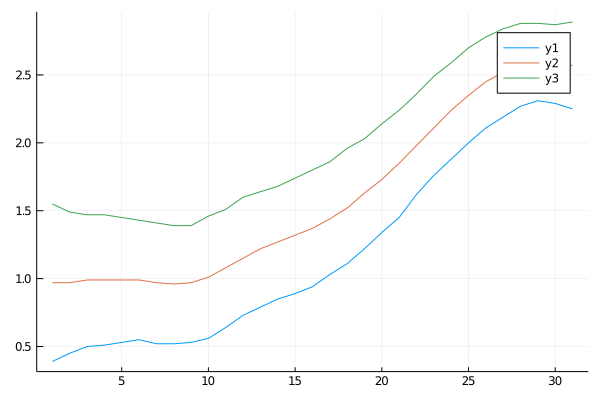

In [123]:
plot_state("tn")

## Comparing against the raw Rt calculation from smoothed numbers

The truefilter smooths the daily rate in accordance with the exponential law. Therefore it is instructive to estimate the Rt from it directly so we can compare against the probabilstic model. The p-model not only gives us the Rt estimate but also the spread, which the raw calculation doesn't give.

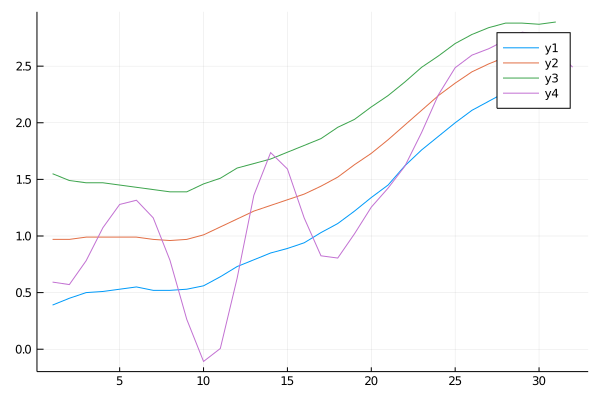

In [124]:
raw_rt(state) = begin
    data = dailies_for_state(state)
    fdata = truefilter(data, smoothing)
    [1+7*log(fdata[i]/fdata[i-1]) for i in 2:length(fdata)]
end
compare_with_raw_rt(sc) = plot([rt_results[sc]["p05"],rt_results[sc]["rt"],rt_results[sc]["p95"],raw_rt(sc)[(end-history_length):end]])
compare_with_raw_rt("tn")

Pick top 5 states according to daily cases.

In [125]:
important_states = [lowercase(x["state_code"]) for x in sort(rt_summary["states"],lt=(a,b) -> a["daily_cases"][end] > b["daily_cases"][end])][1:5]

5-element Array{String,1}:
 "mh"
 "tn"
 "dl"
 "gj"
 "pb"

In [126]:
top5_results = Dict([(sc,run_for_state(filtered_state_data(sc))) for sc in important_states])

┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/srikumar/.julia/packages/Turing/cReBm/src/inference/hmc.jl:556
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:12
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/srikumar/.julia/packages/Turing/cReBm/src/inference/hmc.jl:556
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:17
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/srikumar/.julia/packages/Turing/cReBm/src/inference/hmc.jl:556
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:15
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/srikumar/.julia/packages/Turing/cReBm/src/inference/hmc.jl:556
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:16
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/srikumar/.julia/packages/Turing/cReBm/src/inference/hmc.jl:556
Sampling: 100%|█████████████████████████

Dict{String,Dict{String,Array{Any,1}}} with 5 entries:
  "dl" => Dict{String,Array{Any,1}}("p95"=>[2.11, 2.09, 2.08, 2.03, 1.95, 1.84,…
  "tn" => Dict{String,Array{Any,1}}("p95"=>[1.54, 1.52, 1.51, 1.47, 1.45, 1.41,…
  "pb" => Dict{String,Array{Any,1}}("p95"=>[2.23, 2.19, 2.19, 2.18, 2.16, 2.14,…
  "gj" => Dict{String,Array{Any,1}}("p95"=>[2.73, 2.71, 2.67, 2.63, 2.58, 2.5, …
  "mh" => Dict{String,Array{Any,1}}("p95"=>[2.11, 2.04, 2.01, 1.98, 1.98, 1.93,…

In [127]:
rt_top5 = [
            Dict(
                "state_code"=>uppercase(state),
                "state_name"=>india_state_codes[state],
                "daily_cases"=>dailies_for_state(state)[end-length(x["rt"])+ix],
                "date"=>date_series[end-length(x["rt"])+ix],
                "p95"=>x["p95"][ix],
                "p25"=>x["p25"][ix],
                "p05"=>x["p05"][ix],
                "rt"=>x["rt"][ix],
                "p75"=>x["p75"][ix],
                "std"=>x["std"][ix])
            for (state,x) in top5_results
            for ix in 1:length(x["rt"])
        ]


open("data/rt_india_states.json","w") do f
    JSON.print(f, rt_top5)
end

Checking for TamilNadu

In [128]:
top5_results["tn"]["rt"]

31-element Array{Any,1}:
 0.97
 0.97
 0.99
 1.0
 0.99
 0.98
 0.96
 0.95
 0.96
 1.0
 1.07
 1.15
 1.22
 ⋮
 1.74
 1.86
 1.99
 2.12
 2.24
 2.35
 2.45
 2.52
 2.57
 2.59
 2.59
 2.57